## SETUP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
from keras import utils, models, layers, activations, optimizers, losses, callbacks
from scipy.io import wavfile
from IPython.display import clear_output
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import shutil
import time
import random
import csv
import keras_hub

## UNZIP

In [3]:
!unzip -qqq /content/drive/MyDrive/Research/brain-tumor-mri-dataset.zip -d /content/dataset/

## HYPER PARAMS

In [4]:
class HP:
    seed = 43
    batch_size = 32
    image_shape = (256, 256, 3)
    patch_size = (16, 16)
    num_heads = 4
    num_blocks = 2
    embedding_dim = 256
    ff_dim = 512
    num_classes = 4

## PREPARE THE DATASET

In [5]:
class_names = sorted(os.listdir("/content/dataset/Training"))
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
train_dataset, valid_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dataset/Training/",
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    batch_size=HP.batch_size,
    image_size=HP.image_shape[:-1],
    shuffle=True,
    seed=HP.seed,
    validation_split=0.1,
    subset="both",
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory="/content/dataset/Testing/",
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    batch_size=HP.batch_size,
    image_size=HP.image_shape[:-1],
    shuffle=False,
    seed=HP.seed,
)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.
Using 571 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
train_ds = train_dataset.cache(filename="train_dataset")
valid_ds= valid_dataset.cache(filename="valid_dataset")
test_ds = test_dataset.cache(filename="test_dataset")

## UTILS

In [8]:
@keras.saving.register_keras_serializable()
class STFTSpectrogram(layers.Layer):
    def __init__(self, frame_length=512, sequence_length=128, fft_length=512, **kwargs):
        super().__init__(**kwargs)
        self.frame_length = frame_length
        self.sequence_length = sequence_length
        self.fft_length = fft_length

    def call(self, inputs):
        stft_output = tf.signal.stft(
            signals=inputs,
            frame_length=self.frame_length,
            frame_step=self.sequence_length,
            fft_length=self.fft_length,
            pad_end=True,
        )
        magnitude_spectrogram = tf.abs(stft_output)
        log_spectrogram = tf.math.log1p(magnitude_spectrogram)
        return log_spectrogram[..., None]

    def get_config(self):
        config = super().get_config()
        config.update({
            "frame_length": self.frame_length,
            "sequence_length": self.sequence_length,
            "fft_length": self.fft_length
        })
        return config

In [9]:
@keras.saving.register_keras_serializable()
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = keras.ops.image.extract_patches(x, self.patch_size, padding="same")
        batch_size = keras.ops.shape(patches)[0]
        n_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dim = tf.shape(patches)[3]
        output = keras.ops.reshape(patches, (batch_size, n_patches, patch_dim))
        return output

    def config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [10]:
@keras.saving.register_keras_serializable()
class PatchEncoder(keras.models.Model):
    def __init__(self, n_patches, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_patches = n_patches
        self.embedding_dim = embedding_dim
        self.projection = keras.layers.Dense(units=embedding_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=n_patches, output_dim=embedding_dim
        )

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.embedding_dim,)

    def call(self, x):
        positions = tf.range(start=0, limit=self.n_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        projected = self.projection(x)
        encoded = projected + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_patches": self.n_patches,
            "embedding_dim": self.embedding_dim,
        })
        return config

In [11]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the training history.

    Parameters:
    - history: The history object returned by model.fit, containing the training and validation metrics.
    """
    # Extract data from history
    training_loss = history.history.get('loss', [])
    validation_loss = history.history.get('val_loss', [])
    training_accuracy = history.history.get('accuracy', [])
    validation_accuracy = history.history.get('val_accuracy', [])

    epochs = range(1, len(training_loss) + 1)

    # Set the plot style
    plt.style.use('seaborn-v0_8-whitegrid')  # Use 'ggplot' for better compatibility

    # Create the figure
    plt.figure(figsize=(20, 5))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'o-', label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, 'o-', label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)  # Ensure epochs are displayed as integers
    plt.legend(fontsize=10)

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'o-', label='Training Accuracy', color='blue')
    plt.plot(epochs, validation_accuracy, 'o-', label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Number of Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)  # Ensure epochs are displayed as integers
    plt.legend(fontsize=10)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [12]:
def save_history_to_txt(history, filename="training_history.txt"):
    num_epochs = len(history.history['accuracy'])

    headers = ["Epoch", "Train_Accuracy", "Train_Loss", "Val_Accuracy", "Val_Loss", "Learning_Rate"]

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for epoch in range(num_epochs):
            writer.writerow([
                epoch + 1,
                history.history["accuracy"][epoch],
                history.history["loss"][epoch],
                history.history["val_accuracy"][epoch],
                history.history["val_loss"][epoch],
                # history.history["learning_rate"][epoch]
            ])

    print(f"Training history saved to {filename}")

## CONV BLOCKS

In [13]:
# @title ConvStem
@keras.saving.register_keras_serializable()
class ConvStem(layers.Layer):
    def __init__(self, filters, patch_size, extra_args={}, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.patch_size = patch_size
        self.extra_args = extra_args

    def build(self, input_shape):
        self.conv_layer = layers.Conv2D(
            filters=self.filters,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding="valid",
            **self.extra_args
        )
        self.activation_layer = layers.LeakyReLU(negative_slope=0.25)
        self.batch_norm_layer = layers.BatchNormalization()
        super().build(input_shape)

    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.activation_layer(x)
        x = self.batch_norm_layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "patch_size": self.patch_size,
            "extra_args": self.extra_args
        })
        return config

## CREATE MODEL

In [ ]:
def augmentation(x):
    x = layers.RandomFlip(mode="horizontal")(x)
    return x

In [ ]:
def create_vit_model(input_shape, patch_size, num_heads, embedding_dim, ff_dim, num_blocks, output_dimension):
    inputs = layers.Input(shape=input_shape)
    x = augmentation(inputs)
    x = layers.Rescaling(scale=1.0 / 255)(x)

    x = Patches(patch_size=patch_size)(x)
    x = PatchEncoder(n_patches=x.shape[1], embedding_dim=embedding_dim)(x)

    for _ in range(num_blocks):
        x = keras_hub.layers.TransformerEncoder(
            intermediate_dim=ff_dim,
            num_heads=num_heads,
            dropout=0.1,
            activation="relu"
        )(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(256, activation="gelu")(x)

    outputs = layers.Dense(output_dimension, activation="softmax")(x)

    return models.Model(inputs=inputs, outputs=outputs)


model = create_vit_model(
    input_shape=HP.image_shape,
    patch_size=HP.patch_size,
    num_heads=HP.num_heads,
    embedding_dim=HP.embedding_dim,
    ff_dim=HP.ff_dim,
    num_blocks=HP.num_blocks,
    output_dimension=HP.num_classes
)

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=tf.sqrt(2.0 / np.pi),
        beta_2=0.999,
        epsilon=1e-6
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patches_6 (Patches)             │ (None, 256, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_6 (PatchEncoder)  │ (None, 256, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_13          │ (None, 256, 256)       │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_14          │ (None, 256, 256)       │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,428 (5.28 MB)

 Trainable params: 1,383,428 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

## TRAIN

In [ ]:
def lr_scheduler(epoch):
    if epoch + 1 <= 20:
        return 1e-4
    else:
        return 1e-5

lr_schedule = keras.callbacks.LearningRateScheduler(lr_scheduler)

def best_model_saver_function(filepath="best_model_01.keras"):
    return keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        verbose=1
    )

best_model_saver = best_model_saver_function()

In [ ]:
start_time = time.time()
history = model.fit(
    train_ds,
    epochs=35,
    validation_data=valid_ds,
    callbacks=[lr_schedule, best_model_saver]
)
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

Epoch 1/35
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3857 - loss: 1.3186
Epoch 1: val_loss improved from inf to 0.84476, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.3862 - loss: 1.3178 - val_accuracy: 0.6900 - val_loss: 0.8448 - learning_rate: 1.0000e-04
Epoch 2/35
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6810 - loss: 0.8553
Epoch 2: val_loss improved from 0.84476 to 0.58925, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6812 - loss: 0.8546 - val_accuracy: 0.7916 - val_loss: 0.5892 - learning_rate: 1.0000e-04
Epoch 3/35
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7624 - loss: 0.6225
Epoch 3: val_loss improved from 0.58925 to 0.52978, saving model to best_model_01.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7625 - loss: 0.6224 - val_accuracy: 0.8126 - val_loss: 0.5298 - learning_rate: 1.0000e-04
Epoch 4/35
161/161 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
save_history_to_txt(history, filename="vision_transformer_history.txt")

Training history saved to vision_transformer_history.txt


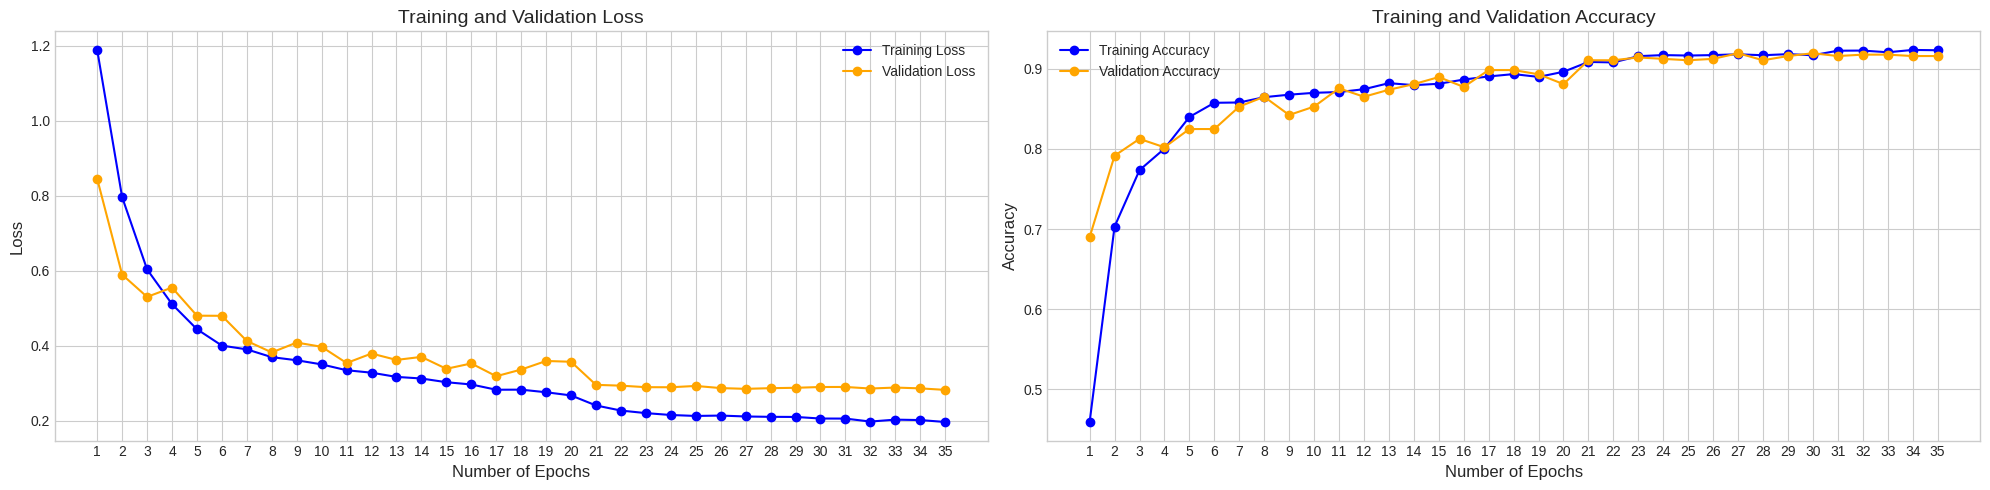

In [ ]:
plot_training_history(history)

## EVALUATE

In [ ]:
best_vl_model = keras.models.load_model("best_model_01.keras")
loss, accuracy = best_vl_model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.8750 - loss: 0.3022
Test loss: 0.3176761269569397
Test accuracy: 0.8703280091285706


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8750 - loss: 0.3022
Test loss: 0.3176761269569397
Test accuracy: 0.8703280091285706


In [ ]:
best_vl_model.save("/content/drive/MyDrive/Research/STCNN/final_vision_transformer.keras")

## t-SNE

In [ ]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_vision_transformer.keras")

In [ ]:
def tsne_function(model, dataset):
    embedding_model = keras.models.Model(
        inputs=model.input,
        outputs=loaded_model.get_layer(index=-2).output
    )
    embeddings = embedding_model.predict(dataset)
    labels = []
    for x_batch, y_batch in dataset:
        labels.append(y_batch.numpy())
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=HP.seed)
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8), dpi=1200)
    num_classes = len(np.unique(labels))
    for i in range(num_classes):
        indices = labels == i
        plt.scatter(
            tsne_embeddings[indices, 0],
            tsne_embeddings[indices, 1],
            label=f'Class {i}',
            alpha=0.6,
            s=15
        )

    plt.legend()
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

In [ ]:
tsne_function(loaded_model, test_ds)

Output hidden; open in https://colab.research.google.com to view.

## FEATURE_MAPS

## METRICS

In [14]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/Research/STCNN/final_vision_transformer.keras")

In [15]:
y_true = []
for x_batch, y_batch in test_dataset:
    y_true.append(y_batch.numpy())

y_true = np.concatenate(y_true, axis=0)

y_pred = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=-1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step


In [18]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.94      0.76      0.84       300
  meningioma       0.74      0.73      0.74       306
     notumor       0.87      0.99      0.92       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.87      1311
   macro avg       0.87      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311

